### Importing necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import zeros, expand_dims, ones, asarray
from numpy.random import randn, randint
from keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, Concatenate, LeakyReLU, Dropout, Embedding, BatchNormalization, Activation

from keras import initializers
from keras.initializers import RandomNormal

from math import sqrt

%matplotlib inline

C:\Users\Akhsay\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Loading Dataset

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
# Printing the shape of the entire dataset
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


So we have 60K training images and 10K test images each of size 28X28 pixels. Here we actually do not require labels are we are working with GAN networks.

In [4]:
# we are dividing each pixel value by 127.5 and subtracting it from 1 to have pixel values in the range of -1 to 1
X_train = X_train.astype(np.float32) / 127.5 - 1

In [5]:
# we are expanding the one dimension of training sample
X_train = np.expand_dims(X_train, axis=3)

In [6]:
# printing the shape of X_train after expanding dimension
print(X_train.shape)

(60000, 28, 28, 1)


We are using the below function to generate latent points of the shape n_samples * latent_dim. This function will generate the random normally distributed n_samples from z-space.

In [7]:
def generate_latent_points(latent_dims, n_samples):
  x_input = randn(latent_dims * n_samples)
  z_input = x_input.reshape(n_samples, latent_dims)
  #print(x_input.shape, x_input.shape)
  return z_input

In [36]:
# This function will generate random n_samples from dataset and label them as 1.
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples) 
    X = X_train[ix]
    y = ones((n_samples, 1))
    return X, y

In [39]:
# This function will generate random n_samples from z-space and label them as 0.
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)  
    y = zeros((n_samples, 1))
    return images, y

Below 2 functions are used the evaluate the model performance.

In [52]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        plt.subplot(10, 10, 1 + i)
        plt.axis('off')
        plt.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

In [53]:
def save_plot(examples, n_examples):
    for i in range(n_examples):
        plt.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')

### Model Building

Here we are defining the discriminator network. It will 28X28 images flatten it and then passes through multiple fully connected dense layers with dropout and activation function.

In [13]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)  
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(learning_rate=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [14]:
discriminator = define_discriminator()

In [15]:
# Discriminator model summary
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 1024)              803840    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0     

We are using a couple of Dense layers to define the generator model with again leaky relu as an activation function in hidden layers and tanh in the final layer. The generated images G(z) will be of the shape 28x28x1.

In [16]:
def define_generator(latent_dim): 
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,)) 
    print(in_lat.shape)
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model

In [17]:
generator = define_generator(100)

(None, 100)


In [18]:
# Generator model summary
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_4 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1024)              0   

Combining the generator and discriminator model. We are freezing the discriminator, providing z as input and D(G(z)) as an output to our model. We are using adam as an optimizer and binary cross-entropy as a loss function.

In [19]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [20]:
# function calling
gan_model = define_gan(generator, discriminator)

In [21]:
# combined model summary
gan_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_4 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1024)              0   

### Model Training

Below function helps us to train the generator and the discriminator. To train the Discriminator, it first generates real samples, updates the discriminator’s weights, generates fake samples, and then updates the discriminator’s weights again. To train the Generator, it first generates latent points from z-space, generates labels as 1 to fool the discriminator, and then updates the generator’s weights. Finally, the function summarizes the performance of the model after some steps.

In [42]:
def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs, n_batch):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    #print(bat_per_epo, n_steps)
    for i in range(n_steps):
      #print(i)
      X_real, y_real = generate_real_samples(X_train, n_batch)
      d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
      d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
      z_input = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1)) 
      g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
      print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
      if (i+1) % (bat_per_epo * 1) == 0:
        summarize_performance(i, g_model, latent_dim)

>1, dr[0.391,0.812], df[0.313,0.906], g[3.278,0.000]
>2, dr[0.203,0.891], df[0.196,0.961], g[3.208,0.008]
>3, dr[0.277,0.859], df[0.427,0.859], g[3.524,0.008]
>4, dr[0.246,0.898], df[0.183,0.977], g[3.397,0.000]
>5, dr[0.485,0.789], df[0.591,0.797], g[2.974,0.000]
>6, dr[0.434,0.797], df[0.384,0.891], g[2.856,0.000]
>7, dr[0.289,0.867], df[0.402,0.891], g[3.409,0.000]
>8, dr[0.436,0.789], df[0.309,0.898], g[3.029,0.000]
>9, dr[0.273,0.852], df[0.343,0.891], g[3.269,0.000]
>10, dr[0.284,0.859], df[0.257,0.914], g[3.433,0.000]
>11, dr[0.515,0.750], df[0.514,0.812], g[3.159,0.008]
>12, dr[0.218,0.891], df[0.212,0.938], g[3.867,0.000]
>13, dr[0.614,0.680], df[0.448,0.820], g[2.912,0.008]
>14, dr[0.272,0.867], df[0.330,0.898], g[3.751,0.000]
>15, dr[0.373,0.797], df[0.153,0.984], g[3.072,0.000]
>16, dr[0.235,0.875], df[0.420,0.883], g[3.928,0.000]
>17, dr[0.456,0.758], df[0.213,0.977], g[3.202,0.008]
>18, dr[0.295,0.875], df[0.332,0.898], g[3.352,0.008]
>19, dr[0.252,0.883], df[0.198,0.945]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


>Saved: model_0936.h5


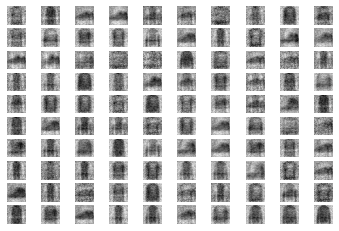

In [43]:
# Training model with 100 random samples, 2 epochs, and 128 as batch size.
latent_dim = 100
train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=2, n_batch=128)

### Generating Samples Using GAN

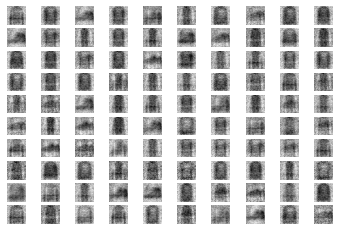

In [55]:
model = load_model('model_0936.h5')
latent_dim = 100
n_examples = 100
latent_points = generate_latent_points(latent_dim, n_examples)
X  = model.predict(latent_points)
X = (X + 1) / 2.0
save_plot(X, n_examples)